In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [2]:
# !pip install pyproj

In [3]:
# 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# 1. 라이브러리 설치 및 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px

# 브랜드지수가 낮으면 폐업률이 높은가

=== 프렌차이즈별 폐업률 현황 (10개 이상 매장) ===
       브랜드  전체매장수  폐업매장수  폐업률(%)
18    카페베네     55     51    92.7
15    탐앤탐스     32     27    84.4
30     드롭탑     11      9    81.8
28    커피베이    127    101    79.5
22   엔제리너스     59     46    78.0
11     셀렉토     48     36    75.0
20   셀렉토커피     48     36    75.0
9     토프레소     33     24    72.7
21    달콤커피     10      7    70.0
24    커피나무     19     13    68.4
7   커피에반하다    131     89    67.9
16    커피마마     20     13    65.0
23    그라찌에     16     10    62.5
14     커피빈     30     18    60.0
10     할리스     63     37    58.7
4     파스쿠찌     39     22    56.4
12    만랩커피     25     13    52.0
8      더카페     42     21    50.0
17    감성커피     36     13    36.1
26     이디야    140     50    35.7

=== 브랜드지수와 폐업률 상관계수: -0.557 ===
→ 음의 상관관계: 브랜드지수가 높을수록 폐업률이 낮아지는 경향


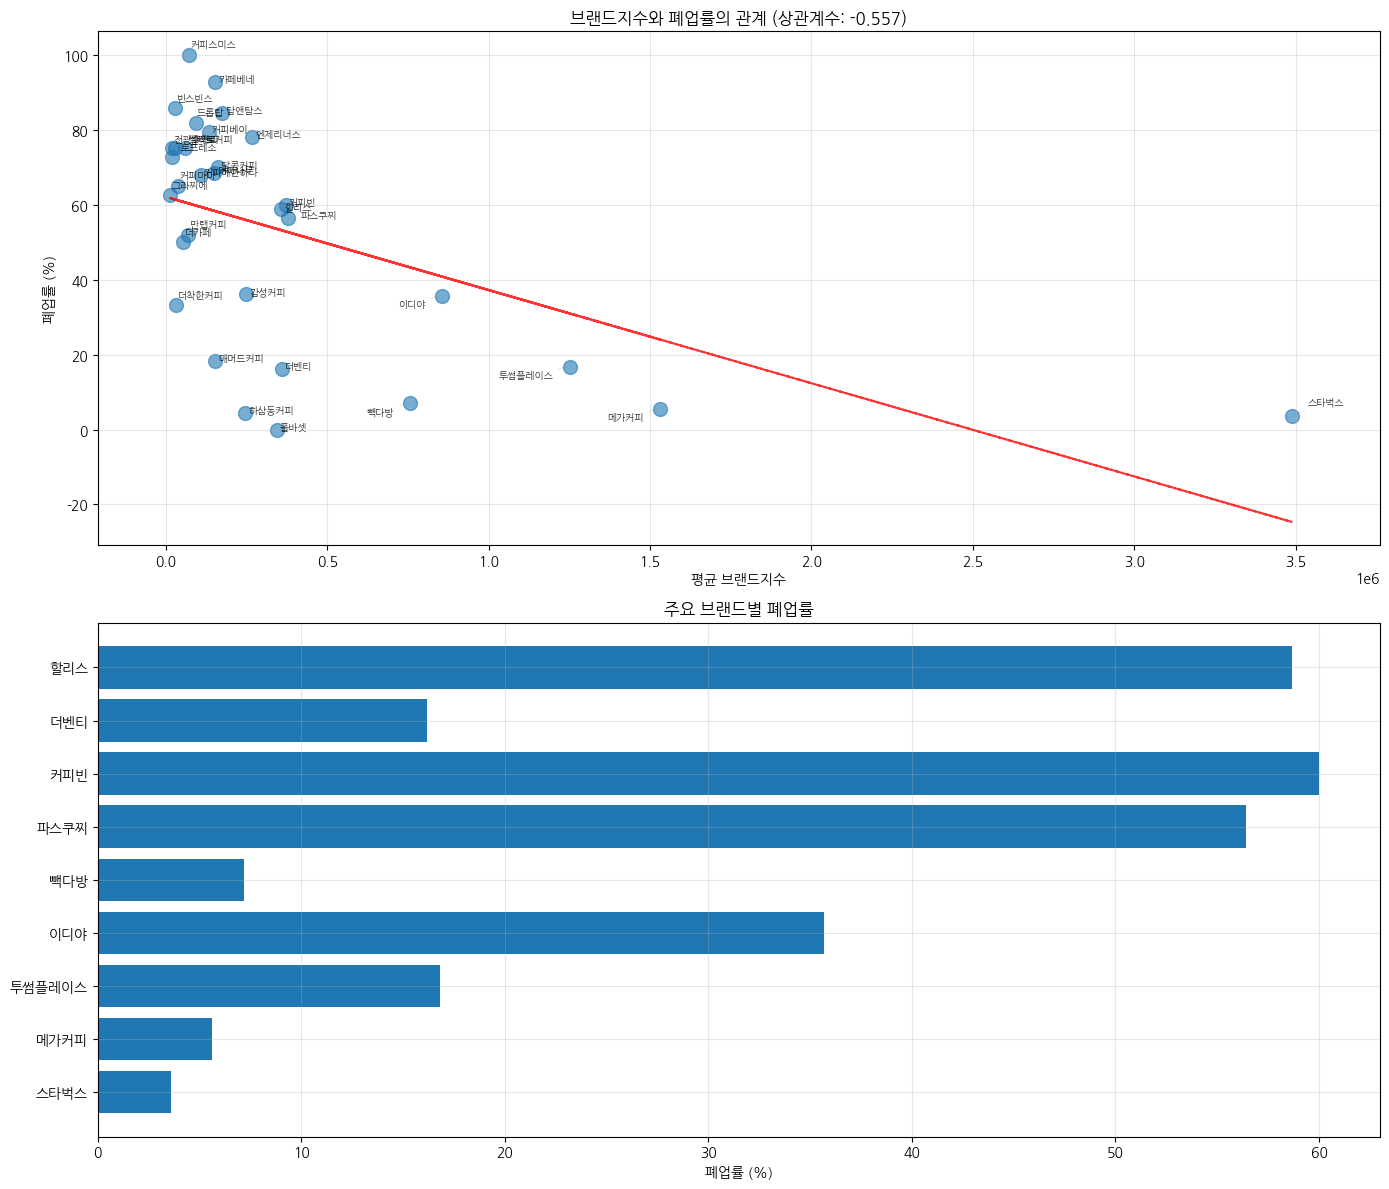


=== 연도별 주요 브랜드 폐업 추이 ===

스타벅스: 197개 매장 중 7개 폐업

투썸플레이스: 155개 매장 중 26개 폐업

메가커피: 18개 매장 중 1개 폐업

이디야: 140개 매장 중 50개 폐업

빽다방: 166개 매장 중 12개 폐업


In [ ]:
# 1. 데이터 로드
# 카페 현황 데이터
df_cafe = pd.read_csv("data/processed/cafe_data.csv")

# 브랜드지수 데이터
df_brand = pd.read_csv("data/processed/brand.csv")

# 2. 프렌차이즈 카페만 필터링
df_franchise = df_cafe[df_cafe['프랜차이즈'] == 1].copy()

# 3. 폐업 여부 확인
df_franchise['폐업여부'] = df_franchise['폐업일자'].notna()

# 4. 날짜 형식 변환
def parse_date(val):
    try:
        val_str = str(val)
        if len(val_str) == 8 and val_str.isdigit():
            return pd.to_datetime(val_str, format="%Y%m%d", errors='coerce')
        return pd.to_datetime(val, errors='coerce')
    except:
        return pd.NaT

df_franchise['인허가일자'] = df_franchise['인허가일자'].apply(parse_date)
df_franchise['폐업일자'] = df_franchise['폐업일자'].apply(parse_date)

# 연도별 추출
df_franchise['인허가연도'] = df_franchise['인허가일자'].dt.year
df_franchise['폐업연도'] = df_franchise['폐업일자'].dt.year

# 5. 주요 프렌차이즈 브랜드 추출 (브랜드지수 데이터에 있는 브랜드)
brand_list = []
for col in df_brand.columns:
    if '_커피' in col:
        brands = df_brand[col].unique()
        brand_list.extend([b for b in brands if pd.notna(b) and b != ''])
brand_list = list(set(brand_list))

# 6. 프렌차이즈별 폐업률 계산
franchise_stats = []
for brand in brand_list:
    # 해당 브랜드 매장만 필터
    brand_stores = df_franchise[df_franchise['사업장명'].str.contains(brand, na=False)]

    if len(brand_stores) > 0:
        total_stores = len(brand_stores)
        closed_stores = len(brand_stores[brand_stores['폐업여부']])
        closure_rate = (closed_stores / total_stores * 100) if total_stores > 0 else 0

        franchise_stats.append({
            '브랜드': brand,
            '전체매장수': total_stores,
            '폐업매장수': closed_stores,
            '폐업률(%)': round(closure_rate, 1)
        })

df_franchise_stats = pd.DataFrame(franchise_stats)
df_franchise_stats = df_franchise_stats.sort_values('폐업률(%)', ascending=False)

print("=== 프렌차이즈별 폐업률 현황 (10개 이상 매장) ===")
print(df_franchise_stats[df_franchise_stats['전체매장수'] >= 10].head(20))

# 7. 브랜드지수 평균 계산
brand_avg_scores = {}
for brand in brand_list:
    scores = []
    for col in df_brand.columns:
        if '_브랜드평판지수' in col:
            brand_data = df_brand[df_brand[col.replace('_브랜드평판지수', '_커피')] == brand][col]
            scores.extend([s for s in brand_data if pd.notna(s)])

    if scores:
        brand_avg_scores[brand] = np.mean(scores)

# 8. 폐업률과 브랜드지수 병합
df_analysis = df_franchise_stats.copy()
df_analysis['평균브랜드지수'] = df_analysis['브랜드'].map(brand_avg_scores)
df_analysis = df_analysis.dropna(subset=['평균브랜드지수'])

# 9. 상관관계 분석
correlation = df_analysis['평균브랜드지수'].corr(df_analysis['폐업률(%)'])
print(f"\n=== 브랜드지수와 폐업률 상관계수: {correlation:.3f} ===")
if correlation < 0:
    print("→ 음의 상관관계: 브랜드지수가 높을수록 폐업률이 낮아지는 경향")
else:
    print("→ 양의 상관관계: 브랜드지수가 높을수록 폐업률이 높아지는 경향")

# 10. 시각화
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14, 12))

# 산점도
ax1.scatter(df_analysis['평균브랜드지수'], df_analysis['폐업률(%)'], alpha=0.6, s=100)

# 브랜드지수로 정렬하여 라벨 위치 조정
df_sorted = df_analysis.sort_values('평균브랜드지수')
prev_y = -999
offset_count = 0

for idx, row in df_sorted.iterrows():
    # 이전 라벨과 y 위치가 비슷하면 오프셋 증가
    if abs(row['폐업률(%)'] - prev_y) < 10:
        offset_count += 1
    else:
        offset_count = 0

    # 브랜드지수에 따라 다른 오프셋 적용
    if row['평균브랜드지수'] < 100000:
        x_offset = 5000 + offset_count * 20000
        y_offset = 2
    elif row['평균브랜드지수'] < 500000:
        x_offset = 10000 + offset_count * 30000
        y_offset = 0
    else:
        x_offset = -50000 if offset_count % 2 == 0 else 50000
        y_offset = -3 if offset_count % 2 == 0 else 3

    ax1.annotate(row['브랜드'],
                xy=(row['평균브랜드지수'], row['폐업률(%)']),
                xytext=(row['평균브랜드지수'] + x_offset, row['폐업률(%)'] + y_offset),
                fontsize=7,
                alpha=0.8,
                ha='left' if x_offset > 0 else 'right',
                arrowprops=dict(arrowstyle='-', alpha=0.3, lw=0.5, color='gray'))

    prev_y = row['폐업률(%)']

# 추세선 추가
z = np.polyfit(df_analysis['평균브랜드지수'], df_analysis['폐업률(%)'], 1)
p = np.poly1d(z)
ax1.plot(df_analysis['평균브랜드지수'], p(df_analysis['평균브랜드지수']), "r--", alpha=0.8)

ax1.set_xlabel('평균 브랜드지수')
ax1.set_ylabel('폐업률 (%)')
ax1.set_title(f'브랜드지수와 폐업률의 관계 (상관계수: {correlation:.3f})')
ax1.grid(True, alpha=0.3)

# x축 범위 확장 (라벨이 잘리지 않도록)
x_min, x_max = ax1.get_xlim()
ax1.set_xlim(x_min - 50000, x_max + 100000)

# 상위 10개 브랜드 막대그래프
top_brands = df_analysis.nlargest(9, '평균브랜드지수')
ax2.barh(top_brands['브랜드'], top_brands['폐업률(%)'])
ax2.set_xlabel('폐업률 (%)')
ax2.set_title('주요 브랜드별 폐업률')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11. 시계열 분석 (선택적)
print("\n=== 연도별 주요 브랜드 폐업 추이 ===")
major_brands = ['스타벅스', '투썸플레이스', '메가커피', '이디야', '빽다방']
for brand in major_brands:
    brand_stores = df_franchise[df_franchise['사업장명'].str.contains(brand, na=False)]
    if len(brand_stores) > 0:
        yearly_closure = brand_stores.groupby('폐업연도').size()
        print(f"\n{brand}: {len(brand_stores)}개 매장 중 {brand_stores['폐업여부'].sum()}개 폐업")

# 결과 저장
df_analysis.to_csv('data/processed/프렌차이즈_폐업률_브랜드지수_분석.csv', index=False, encoding='utf-8-sig')

#브랜드지수가 낮아지면 폐업률이 높아지는가

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


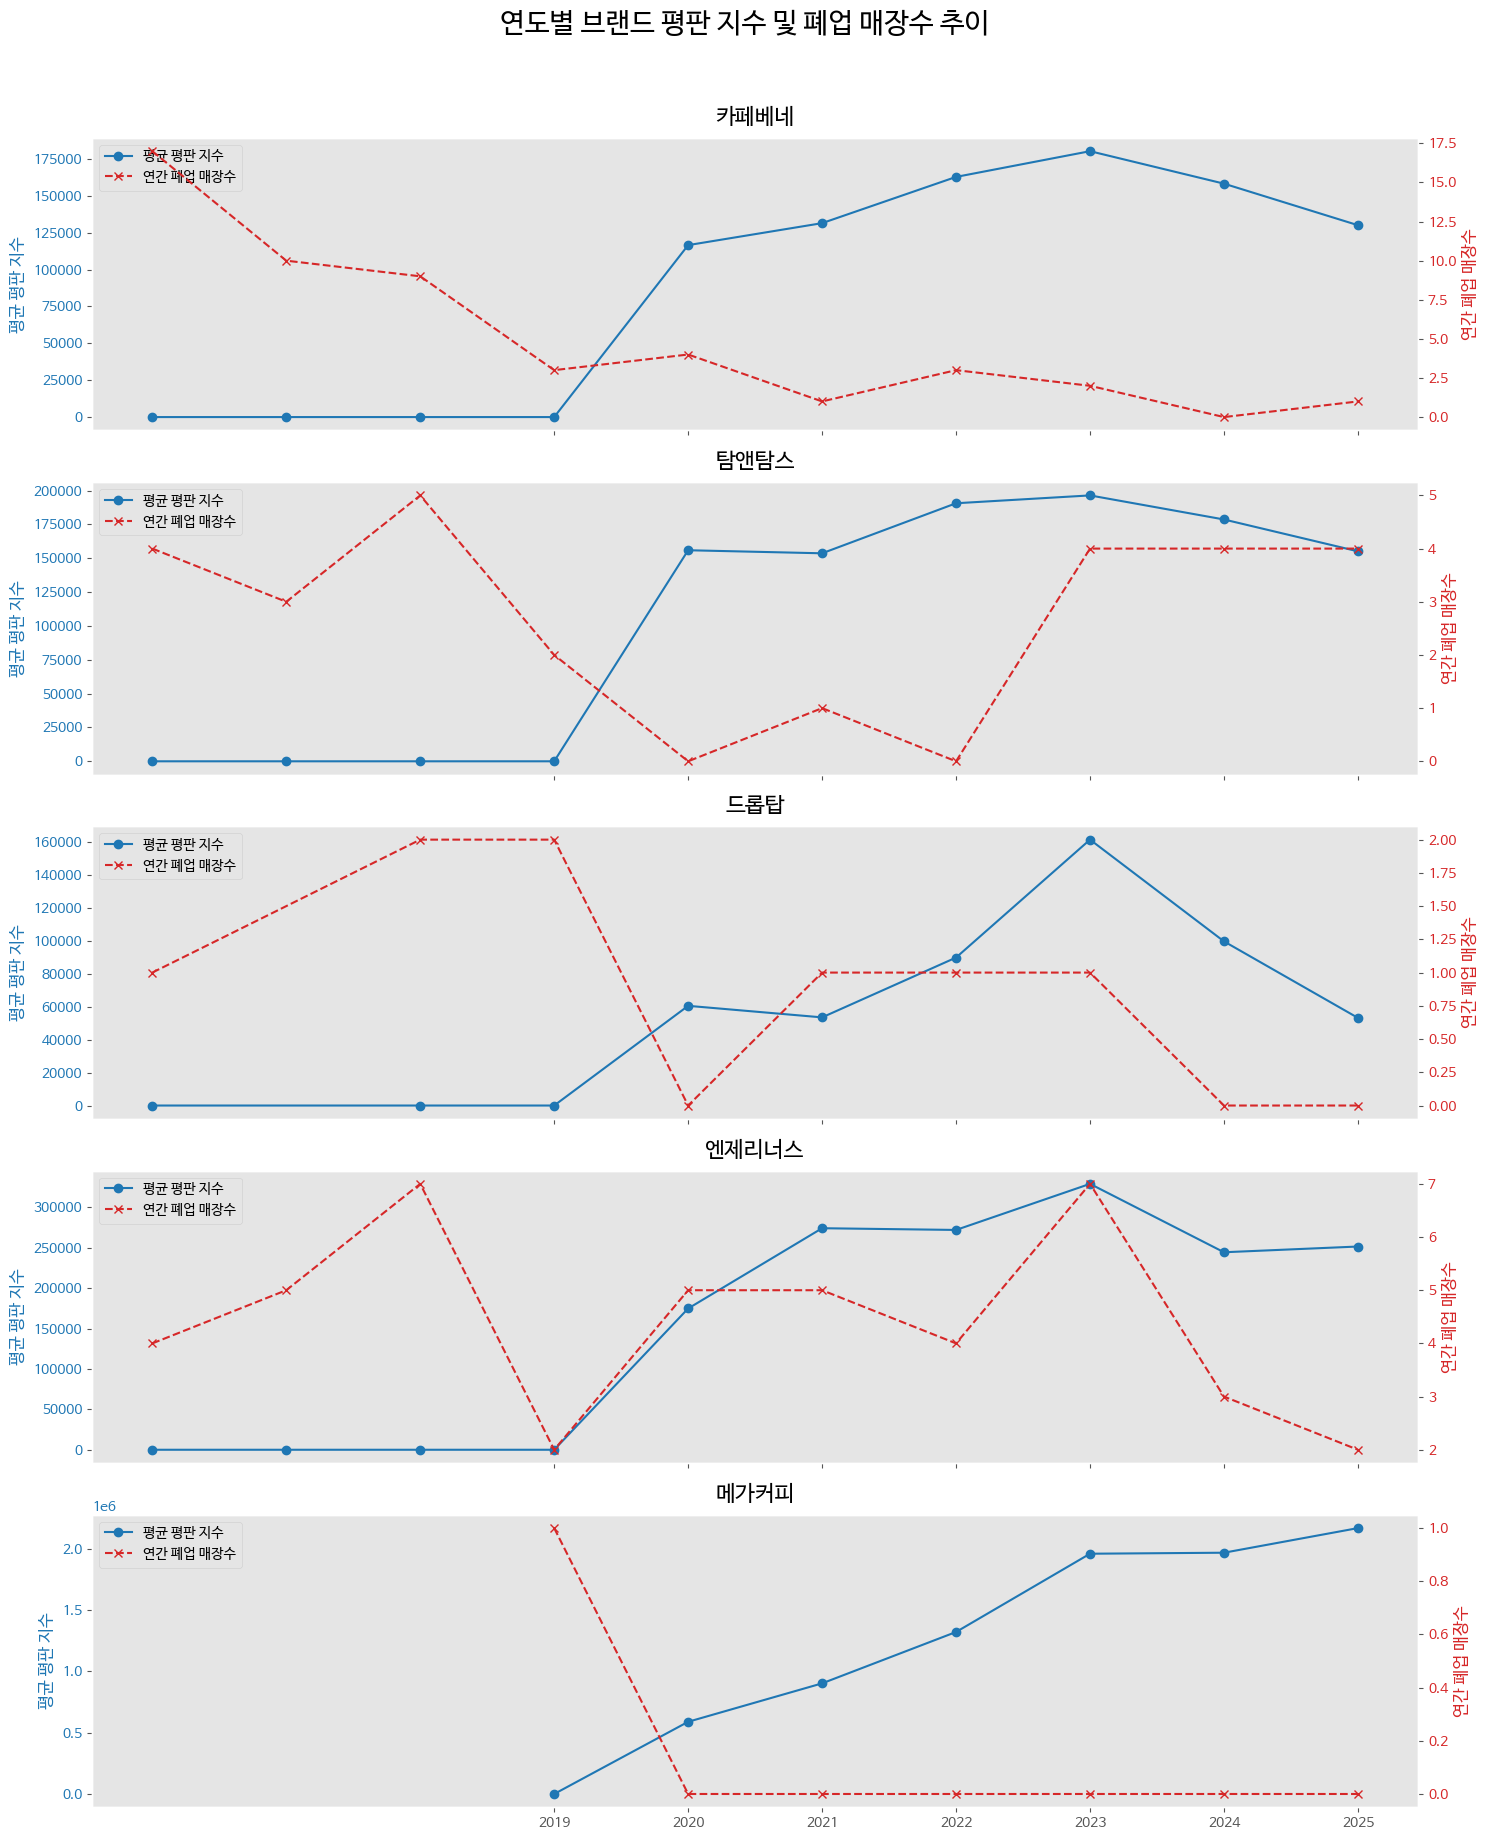

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------
# 1. 데이터 로드 및 전처리 (이전 코드와 동일)
# ----------------------------------------
df_cafe = pd.read_csv("data/processed/cafe_data.csv")
df_brand = pd.read_csv("data/processed/brand.csv")

def parse_date(val):
    try:
        val_str = str(val)
        if len(val_str) == 8 and val_str.isdigit():
            return pd.to_datetime(val_str, format="%Y%m%d", errors='coerce')
        return pd.to_datetime(val, errors='coerce')
    except:
        return pd.NaT

df_cafe['인허가일자'] = df_cafe['인허가일자'].apply(parse_date)
df_cafe['폐업일자'] = df_cafe['폐업일자'].apply(parse_date)

# 연도별 폐업 매장수 계산
df_cafe['폐업연도'] = df_cafe['폐업일자'].dt.year
df_closed_yearly = df_cafe.groupby(['폐업연도', '사업장명'])['사업장명'].count().reset_index(name='폐업수')
df_closed_yearly['사업장명'] = df_closed_yearly['사업장명'].apply(lambda x: x.split(' ')[0] if pd.notna(x) else x)

# 브랜드지수 데이터 전처리 (이전 코드 재활용)
cols_to_melt = [col for col in df_brand.columns if col != '순위']
df_melted = df_brand.melt(id_vars='순위', value_vars=cols_to_melt, var_name='날짜_항목', value_name='값')
df_melted[['날짜', '항목']] = df_melted['날짜_항목'].str.split('_', expand=True)
df_melted['날짜'] = pd.to_datetime(df_melted['날짜'], format='%Y년%m월')
df_score = df_melted[df_melted['항목'] == '브랜드평판지수'].copy()
df_score['값'] = pd.to_numeric(df_score['값'])
df_brand_name = df_melted[df_melted['항목'] == '커피'].copy()
df_brand_monthly = pd.merge(df_brand_name, df_score, on=['순위', '날짜'], suffixes=('_brand', '_score'))
df_brand_monthly = df_brand_monthly.rename(columns={'값_brand': '브랜드', '값_score': '평판지수'})
df_brand_monthly['날짜'] = df_brand_monthly['날짜'].dt.to_period('M')

# ----------------------------------------
# 2. 여러 브랜드에 대한 서브플롯 시각화
# ----------------------------------------

# 분석할 브랜드 목록
target_brands = ['카페베네', '탐앤탐스', '드롭탑', '엔제리너스', '메가커피']

# 서브플롯 생성: 3개의 그래프를 3x1 형태로
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 18), sharex=True)
axes = axes.flatten()

# Colab 환경에서 한글 폰트 설정
try:
    import matplotlib.font_manager as fm
    !apt-get update -qq
    !apt-get install fonts-nanum -qq > /dev/null
    fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
    plt.rc('font', family='NanumBarunGothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

fig.suptitle('연도별 브랜드 평판 지수 및 폐업 매장수 추이', fontsize=20, y=1.02)

for i, brand in enumerate(target_brands):
    ax1 = axes[i]

    # 특정 브랜드의 연도별 데이터
    brand_scores_yearly = df_brand_monthly[df_brand_monthly['브랜드'] == brand].copy()
    brand_scores_yearly['연도'] = brand_scores_yearly['날짜'].dt.year
    brand_scores_yearly = brand_scores_yearly.groupby('연도')['평판지수'].mean().reset_index()

    brand_closures_yearly = df_closed_yearly[df_closed_yearly['사업장명'].str.contains(brand, na=False)].copy()
    brand_closures_yearly = brand_closures_yearly.groupby('폐업연도')['폐업수'].sum().reset_index()
    brand_closures_yearly = brand_closures_yearly.rename(columns={'폐업연도': '연도'})

    df_merged_yearly = pd.merge(brand_scores_yearly, brand_closures_yearly, on='연도', how='outer').fillna(0)
    df_merged_yearly = df_merged_yearly.sort_values('연도').astype({'연도': int})

    # 평판 지수 (Y1축)
    color_brand = 'tab:blue'
    ax1.set_title(f'{brand}', fontsize=16, pad=10)
    ax1.set_ylabel('평균 평판 지수', color=color_brand, fontsize=12)
    ax1.plot(df_merged_yearly['연도'], df_merged_yearly['평판지수'], color=color_brand, marker='o', label='평균 평판 지수')
    ax1.tick_params(axis='y', labelcolor=color_brand)
    ax1.grid(False)

    # 폐업 매장수 (Y2축)
    ax2 = ax1.twinx()
    color_closure = 'tab:red'
    ax2.set_ylabel('연간 폐업 매장수', color=color_closure, fontsize=12)
    ax2.plot(df_merged_yearly['연도'], df_merged_yearly['폐업수'], color=color_closure, marker='x', linestyle='--', label='연간 폐업 매장수')
    ax2.tick_params(axis='y', labelcolor=color_closure)
    ax2.grid(False)

    # 범례 통합 및 위치 조정
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# X축 라벨 조정 (모든 서브플롯에 동일하게 적용)
plt.xticks(df_merged_yearly['연도'].unique())
plt.xlabel('연도', fontsize=14)

plt.tight_layout()
plt.show()

쇠퇴기 브랜드 (카페베네, 탐앤탐스, 드롭탑)
평판 지수(파란색 선)는 전반적으로 하락하거나 낮은 수준에 머무르고 있습니다. 반면, 폐업 매장수(빨간색 점선)는 지속적으로 높게 나타나거나 증가하는 추세입니다.
이 패턴은 **"브랜드 평판 악화가 가맹점 폐업을 유도할 수 있다"**는 가설을 강력하게 뒷받침합니다. 특히, 탐앤탐스 그래프에서 평판 지수가 먼저 하락하고 이후 폐업이 증가하는 시간적 선후 관계가 뚜렷하게 관찰되어, 단순한 상관관계를 넘어 인과 관계를 시사합니다.

전환기 브랜드 (엔젤리너스)
엔젤리너스는 2022년에 평판 지수가 급격히 상승하는 전환점을 맞이합니다. 이후 2023년에는 평판 지수가 하락했지만, 2024년에는 다시 상승하는 등 변동성이 큽니다. 폐업 매장수는 2021년과 2022년에 높았다가 2023년부터 감소하는 추세를 보입니다.
평판 지수가 개선된 이후 폐업 매장수가 감소하는 경향을 보여, **"성공적인 브랜드 리뉴얼이나 마케팅 활동이 평판 개선을 통해 폐업률을 낮출 수 있다"**는 인사이트를 제공합니다. 이는 쇠퇴기 브랜드들과는 다른, 긍정적인 상관관계를 보여주는 사례로 해석할 수 있습니다.

성장기 브랜드 (메가커피)
평판 지수가 압도적으로 높고, 2022년부터 급격한 상승세를 보입니다. 반면, 폐업 매장수는 매우 낮은 수준에 머무르거나 미미한 변동성만 보입니다.
**"높은 브랜드 평판이 매장 수를 확장하고, 폐업률을 낮추는 데 결정적인 역할을 한다"**는 가설을 증명합니다. 특히 평판 지수와 폐업 매장수 간에 뚜렷한 음의 상관관계가 나타나, 성공적인 프랜차이즈의 전형적인 패턴을 보여줍니다.